# **Import Library**

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import plotly.express as px

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.26.4
pandas version :  2.2.1
seaborn version :  0.13.2


In [3]:
# Mengubah parameter default matplotlib

from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'

# **Import Dataset**

In [31]:
# load data
df = pd.read_csv('Train.csv')

# Rename kolom 
df = df.rename(columns={'Warehouse_block':'Warehouse',
                        'Mode_of_Shipment':'Shipment',
                        'Customer_care_calls':'Calls',
                        'Customer_rating':'Rating',
                        'Cost_of_the_Product':'Cost',
                        'Prior_purchases':'Purchases',
                        'Product_importance':'Importance',
                        'Discount_offered':'Discount',
                        'Weight_in_gms':'Weight (gram)',
                        'Reached.on.Time_Y.N':'Late'})

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             10999 non-null  int64 
 1   Warehouse      10999 non-null  object
 2   Shipment       10999 non-null  object
 3   Calls          10999 non-null  int64 
 4   Rating         10999 non-null  int64 
 5   Cost           10999 non-null  int64 
 6   Purchases      10999 non-null  int64 
 7   Importance     10999 non-null  object
 8   Gender         10999 non-null  object
 9   Discount       10999 non-null  int64 
 10  Weight (gram)  10999 non-null  int64 
 11  Late           10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [33]:
#pengelompokkan jenis feature
cat = ['Warehouse', 'Shipment', 'Importance', 'Gender'] 
num = ['Calls', 'Rating', 'Cost', 'Purchases', 'Discount', 'Weight (gram)', 'Late'] 

In [16]:
df.sample(5)

,ID,Warehouse,Shipment,Calls,Rating,Cost,Purchases,Importance,Gender,Discount,Weight (gram),Late
4434,4435,D,Ship,3,3,171,4,low,M,8,4502,0
10120,10121,C,Road,5,4,179,6,medium,M,1,5433,0
10713,10714,B,Ship,5,5,221,5,low,F,8,1123,1
2034,2035,D,Road,3,5,243,2,medium,M,42,3421,1
8135,8136,F,Ship,6,2,213,2,medium,F,7,5415,0


In [34]:
# Summary feature numerical
df[num].describe()

,Calls,Rating,Cost,Purchases,Discount,Weight (gram),Late
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


Beberapa pengamatan:

1. Kolom `Calls`, `Rating`, `Cost`, dan `Weight (gram)` tampak sudah cukup simetrik distribusinya (mean dan median tak berbeda jauh)
2. Kolom `Purchase` dan `Discount` tampaknya skew ke kanan (long-right tail), mungkin dapat dilakukan transformasi log nantinya
3. Kolom `Late` atau target bernilai boolean/binary

In [35]:
# Summary feature categorical
df[cat].describe()

,Warehouse,Shipment,Importance,Gender
count,10999,10999,10999,10999
unique,5,3,3,2
top,F,Ship,low,F
freq,3666,7462,5297,5545


# **Stage 2**

## **1. Data Cleansing**


### A. Handle Missing Value and Duplicate Data

In [5]:
df.isna().sum()

ID               0
Warehouse        0
Shipment         0
Calls            0
Rating           0
Cost             0
Purchases        0
Importance       0
Gender           0
Discount         0
Weight (gram)    0
Late             0
dtype: int64

**Pengamatan: Tidak ada missing value pada data**

### B. Handle Duplicated Data

In [6]:
# cek baris yang duplikat
print(f'Jumlah row duplicated = {df.duplicated().sum()}')

Jumlah row duplicated = 0


**Tidak ada data duplikat pada dataset**

### C. Handle Outliers

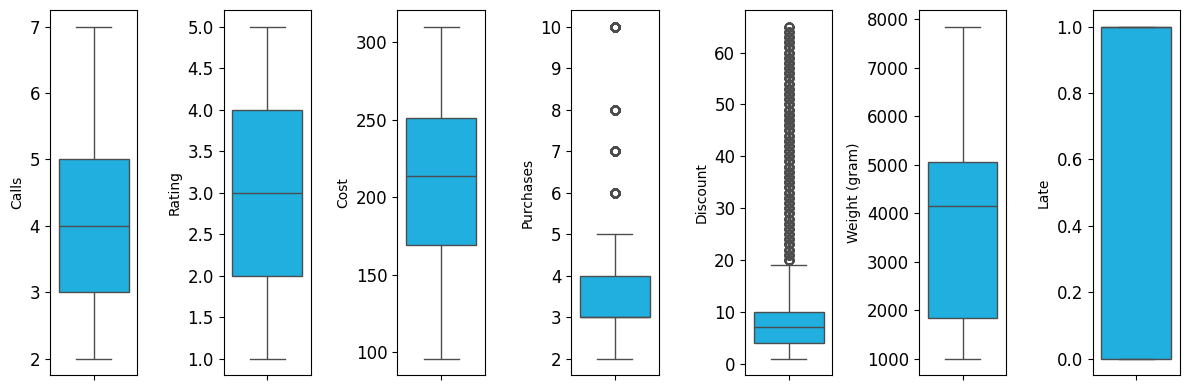

In [39]:
# cek boxplot kolom tipe data int/float untuk melihat outlier

for i in range(0, len(num)):
    plt.subplot(1, len(num), i+1)
    sns.boxplot(y=df[num[i]], color='deepskyblue', orient='v')
    plt.tight_layout()

In [36]:
from scipy import stats

z_scores = np.abs(stats.zscore(df[num]))
outliers = z_scores > 3

# Cek keadaan data setelah outlier dihilangkan
cleaned_df = df[~outliers.any(axis=1)]

# Menampilkan hasil
print("Jumlah outlier:")
print(outliers.sum())

print(f'\nJumlah baris sebelum memfilter outlier: {len(df)}')
print(f'Jumlah baris setelah memfilter outlier: {len(cleaned_df)}')

Jumlah outlier:
Calls              0
Rating             0
Cost               0
Purchases        178
Discount         181
Weight (gram)      0
Late               0
dtype: int64

Jumlah baris sebelum memfilter outlier: 10999
Jumlah baris setelah memfilter outlier: 10642


In [15]:
# Distribusi "Yes" dan "No" pada kolom "Late" di df
df_distribution = df['Late'].value_counts(normalize=True)

# Distribusi "Yes" dan "No" pada kolom "Late" di cleaned_df
cleaned_df_distribution = cleaned_df['Late'].value_counts(normalize=True)

print("Distribusi 'Yes' dan 'No' pada kolom 'Late' di df:")
print(df_distribution)

print("\nDistribusi 'Yes' dan 'No' pada kolom 'Late' di cleaned_df:")
print(cleaned_df_distribution)


Distribusi 'Yes' dan 'No' pada kolom 'Late' di df:
Late
1    0.596691
0    0.403309
Name: proportion, dtype: float64

Distribusi 'Yes' dan 'No' pada kolom 'Late' di cleaned_df:
Late
1    0.590303
0    0.409697
Name: proportion, dtype: float64


- Persentase distribusi ini masih aman, sehingga dapat dipertimbangkan untuk mempertahankan outlier dan menggunakan robust scale

Kita akan menggunakan Z-score filtering (cenderung lebih konservatif)

### D. Feature Transformation


__*Log Tranformation*__

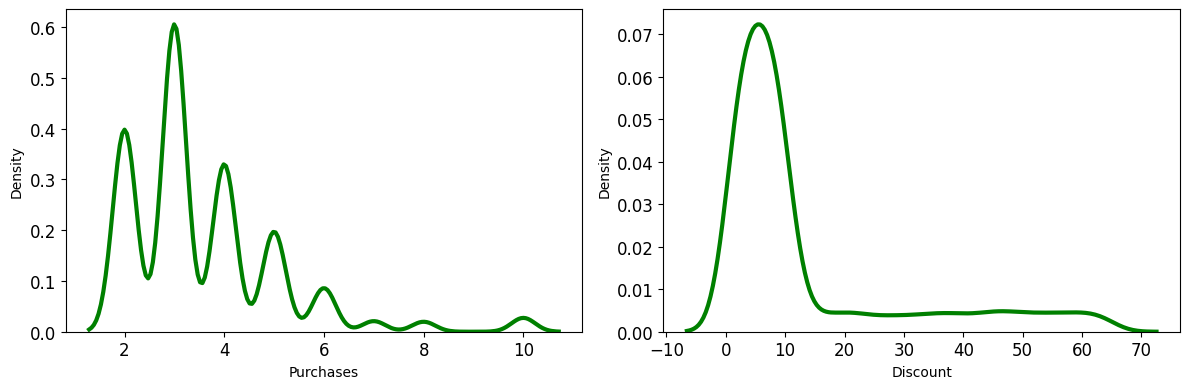

In [50]:
# cek distribusi kolom Purchase dan Discount

log_trans = ['Purchases', 'Discount']

for i in range(0, len(log_trans)):
    plt.subplot(1, len(log_trans), i+1)
    sns.kdeplot(x=df[log_trans[i]], color='green')
    plt.tight_layout()

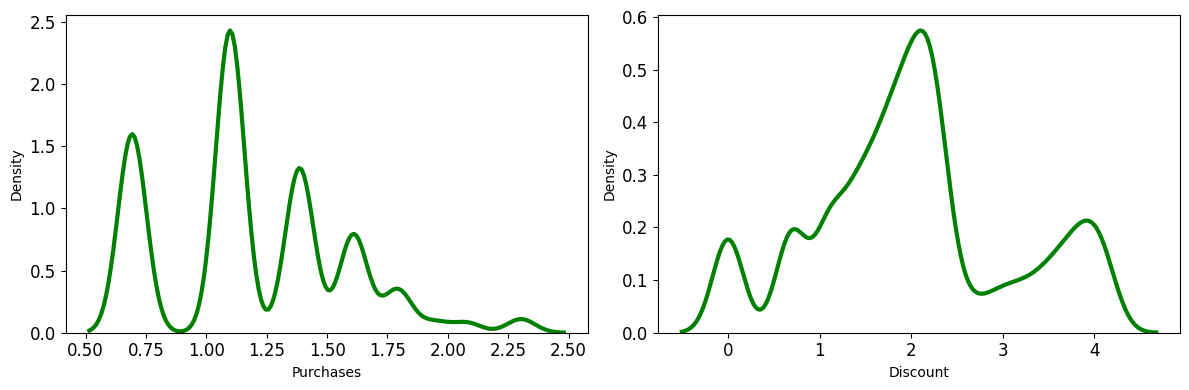

In [51]:
# distribusi purchases dan discount (setelah log transformation)
for i in range(0, len(log_trans)):
    plt.subplot(1, len(log_trans), i+1)
    sns.kdeplot(np.log(df[log_trans[i]]), color='green')
    plt.tight_layout()
    
# lebih mendekati distribusi normal!

In [108]:
# skewness sebelum transformasi
skewness_before = df[num].skew()
print("Skewness sebelum transformasi:")
print(skewness_before)

log_df = df.copy()

# log transformation pada fitur numerik
log_df[num] = log_df[num].apply(lambda x: np.log(x + 1))

# skewness setelah transformasi
skewness_after = log_df[num].skew()
print("\nSkewness setelah transformasi:")
print(skewness_after)

# Menghitung pengurangannya
skewness_reduction = skewness_before - skewness_after
print("\nPengurangan skewness:")
print(skewness_reduction)

Skewness sebelum transformasi:
Calls            0.391926
Rating           0.004360
Cost            -0.157117
Purchases        1.681897
Discount         1.798929
Weight (gram)   -0.249747
Late            -0.394257
dtype: float64

Skewness setelah transformasi:
Calls           -0.132074
Rating          -0.401241
Cost            -0.552816
Purchases        0.666819
Discount         0.532220
Weight (gram)   -0.630281
Late            -0.394257
dtype: float64

Pengurangan skewness:
Calls            5.240000e-01
Rating           4.056005e-01
Cost             3.956991e-01
Purchases        1.015078e+00
Discount         1.266709e+00
Weight (gram)    3.805343e-01
Late            -1.110223e-16
dtype: float64


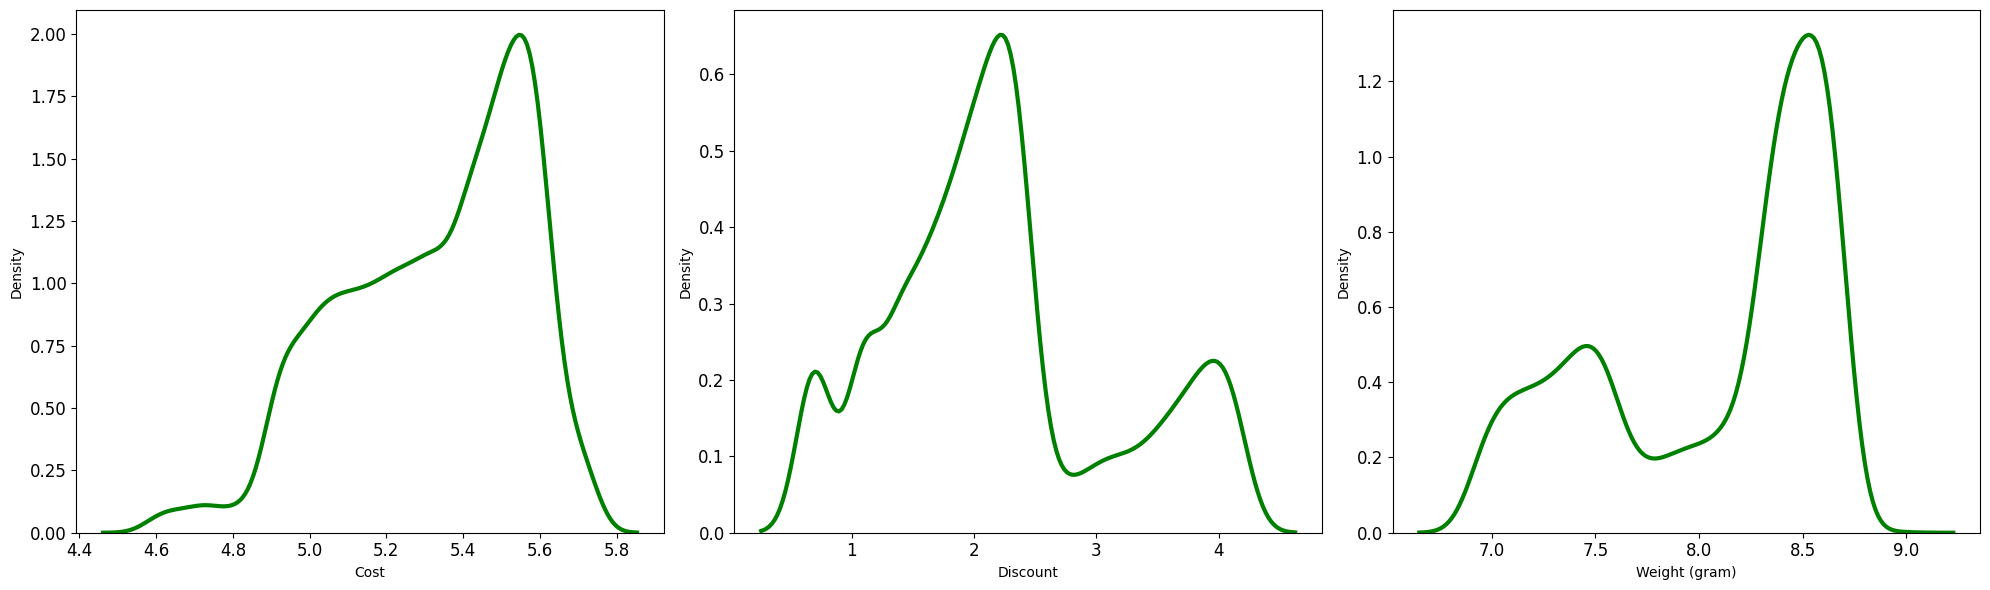

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns


num_log = ['Cost', 'Discount', 'Weight (gram)']

# Menampilkan distribusi setelah log transformation untuk semua fitur numerik
plt.figure(figsize=(20, 6))
for i in range(0, len(num_log)):
    plt.subplot(1, len(num_log), i+1)
    sns.kdeplot(x=log_df[num_log[i]], color='green')
    plt.tight_layout()

plt.show()


__*Normalisasi*__

In [41]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

norm_df = df.copy()

# Min-Max Scaling
scaler = MinMaxScaler()
norm_df[num] = scaler.fit_transform(df[num])

# Menampilkan skewness sebelum transformasi
skewness_before_norm = df[num].skew()
print("\nSkewness sebelum normalisasi:")
print(skewness_before_norm)

# Periksa skewness setelah normalisasi
skewness_after_norm = norm_df[num].skew()
print("\nSkewness setelah normalisasi:")
print(skewness_after_norm)

# Menghitung pengurangannya
skewness_reduction_norm = skewness_before_norm - skewness_after_norm
print("\nPengurangan skewness setelah normalisasi:")
print(skewness_reduction_norm)



Skewness sebelum normalisasi:
Calls            0.391926
Rating           0.004360
Cost            -0.157117
Purchases        1.681897
Discount         1.798929
Weight (gram)   -0.249747
Late            -0.394257
dtype: float64

Skewness setelah normalisasi:
Calls            0.391926
Rating           0.004360
Cost            -0.157117
Purchases        1.681897
Discount         1.798929
Weight (gram)   -0.249747
Late            -0.394257
dtype: float64

Pengurangan skewness setelah normalisasi:
Calls            1.831868e-15
Rating          -6.670012e-16
Cost            -4.440892e-16
Purchases        0.000000e+00
Discount         0.000000e+00
Weight (gram)   -3.885781e-16
Late             0.000000e+00
dtype: float64


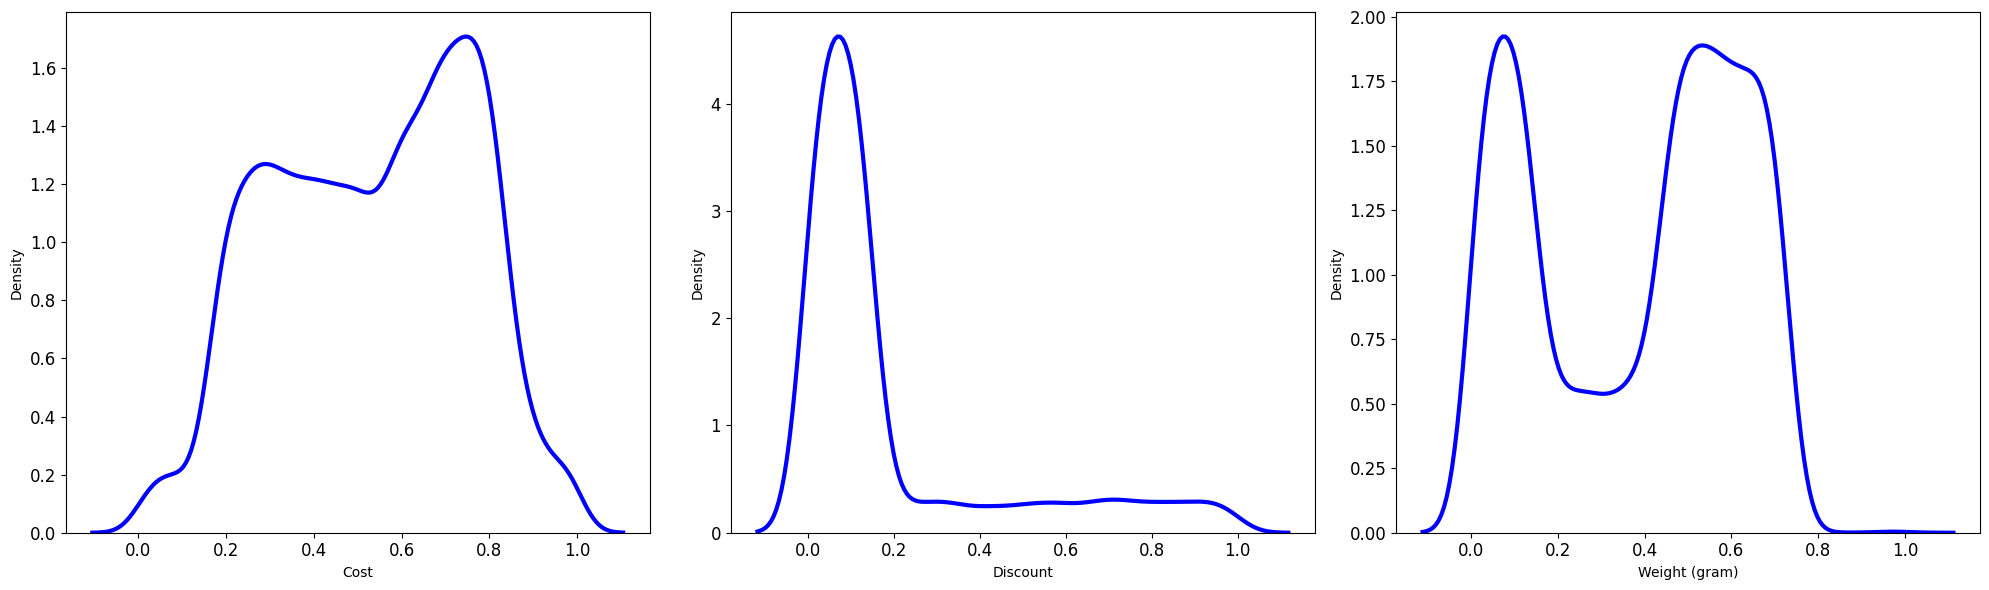

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

num_norm = ['Cost', 'Discount', 'Weight (gram)']

# Menampilkan distribusi setelah normalisasi untuk semua fitur numerik
plt.figure(figsize=(20, 6))
for i in range(0, len(num_norm)):
    plt.subplot(1, len(num_norm), i+1)
    sns.kdeplot(x=norm_df[num_norm[i]], color='blue')
    plt.tight_layout()

plt.show()


__*Standarisasi*__

In [40]:
from sklearn.preprocessing import StandardScaler

# Membuat dataset baru untuk normalisasi
standar_df = df.copy()

# Z-score Standardization
scaler = StandardScaler()
standar_df[num] = scaler.fit_transform(df[num])

# Menampilkan skewness
skewness_before_standar = df[num].skew()
print("\nSkewness sebelum standarisasi:")
print(skewness_before_standar)

# Periksa skewness
skewness_after_standar = standar_df[num].skew()
print("\nSkewness setelah standarisasi:")
print(skewness_after_standar)

# Menghitung pengurangannya
skewness_reduction_standar = skewness_before_standar - skewness_after_standar
print("\nPengurangan skewness setelah standar:")
print(skewness_reduction_standar)



Skewness sebelum standarisasi:
Calls            0.391926
Rating           0.004360
Cost            -0.157117
Purchases        1.681897
Discount         1.798929
Weight (gram)   -0.249747
Late            -0.394257
dtype: float64

Skewness setelah standarisasi:
Calls            0.391926
Rating           0.004360
Cost            -0.157117
Purchases        1.681897
Discount         1.798929
Weight (gram)   -0.249747
Late            -0.394257
dtype: float64

Pengurangan skewness setelah standar:
Calls            8.881784e-16
Rating          -4.250073e-17
Cost            -4.996004e-16
Purchases       -6.661338e-16
Discount        -4.440892e-16
Weight (gram)   -6.661338e-16
Late            -2.220446e-16
dtype: float64


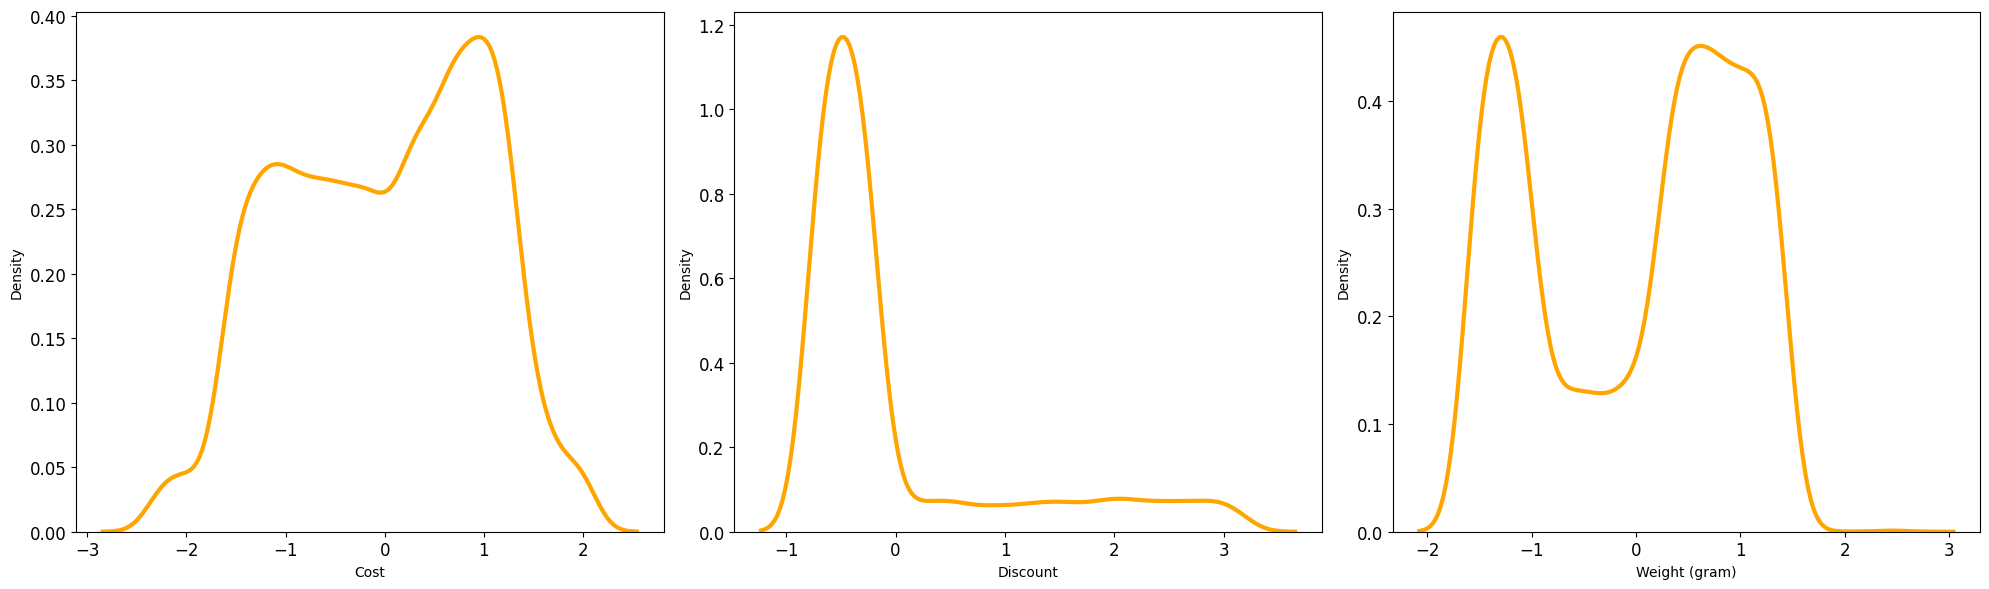

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

num_standar = ['Cost', 'Discount', 'Weight (gram)']

# Menampilkan distribusi setelah standarisasi untuk semua fitur numerik
plt.figure(figsize=(20, 6))
for i in range(0, len(num_standar)):
    plt.subplot(1, len(num_standar), i+1)
    sns.kdeplot(x=standar_df[num_standar[i]], color='orange')
    plt.tight_layout()

plt.show()


__*Robust Scale*__

In [45]:
from sklearn.preprocessing import RobustScaler

# Membuat dataset baru untuk normalisasi
robust_df = df.copy()

# Robust Scaling
scaler = RobustScaler()
robust_df[num] = scaler.fit_transform(df[num])

# Menampilkan skewness
skewness_before_robust = df[num].skew()
print("\nSkewness sebelum Robust Scaling:")
print(skewness_before_robust)

# Periksa skewness
skewness_after_robust = robust_df[num].skew()
print("\nSkewness setelah Robust Scaling:")
print(skewness_after_robust)

# Menghitung pengurangannya
skewness_reduction_robust = skewness_before_robust - skewness_after_robust
print("\nPengurangan skewness setelah Robust Scaling:")
print(skewness_reduction_robust)



Skewness sebelum Robust Scaling:
Calls            0.391926
Rating           0.004360
Cost            -0.157117
Purchases        1.681897
Discount         1.798929
Weight (gram)   -0.249747
Late            -0.394257
dtype: float64

Skewness setelah Robust Scaling:
Calls            0.391926
Rating           0.004360
Cost            -0.157117
Purchases        1.681897
Discount         1.798929
Weight (gram)   -0.249747
Late            -0.394257
dtype: float64

Pengurangan skewness setelah Robust Scaling:
Calls            3.330669e-16
Rating          -2.550044e-16
Cost            -6.383782e-16
Purchases        0.000000e+00
Discount        -4.440892e-16
Weight (gram)   -3.885781e-16
Late            -4.440892e-16
dtype: float64


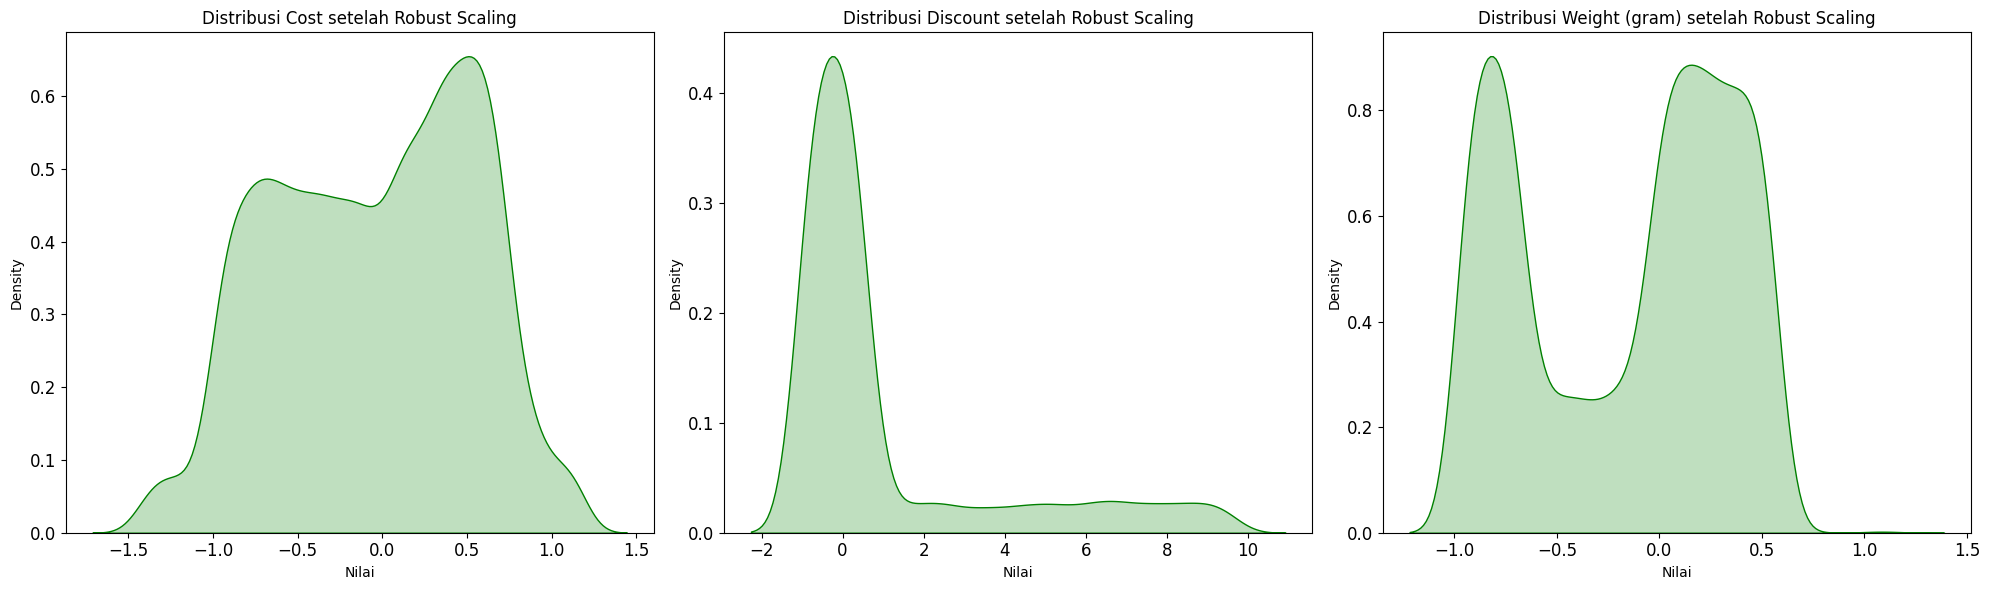

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

num_robust = ['Cost', 'Discount', 'Weight (gram)']

plt.figure(figsize=(20, 6))
for i in range(0, len(num_robust)):
    plt.subplot(1, len(num_robust), i+1)
    sns.kdeplot(data=robust_df[num_robust[i]], color='green', shade=True)
    plt.title(f'Distribusi {num_robust[i]} setelah Robust Scaling')
    plt.xlabel('Nilai')
    plt.ylabel('Density')
    plt.tight_layout()

plt.show()


- Beberapa fitur diuji coba ditransformasi untuk memudahkan pemodelan dan juga membuat fitur mendekati distribusi normal. Dari ketiga transformasi tersebut, Normalisasi memiliki pengurangan skewness terbesar pada fitur `Calls` dan `Rating`, sedangkan Log Transformation memiliki pengurangan skewness terbesar pada fitur `Purchases` dan `Discount`
- Robust Scaling memberikan hasil yang lebih baik daripada Normalisasi atau Standard Scaling dalam mengurangi skewness pada fitur-fitur yang sensitif terhadap outlier seperti `Purchase` dan `Discount`. Sehingga dengan mempertimbangkan percobaan penghilangan outlier pada sebelumnya dan menilai distribusi yes dan no pada `Late` masih proporsional, sehingga robust scaling dipilih untuk fitur transformasi

### E. Feature Encoding

In [59]:
#melihat feature kategorikal
for col in cat:
  print(f'value counts of column {col}')
  print(df[col].value_counts())
  print('---'*10, '\n')

value counts of column Warehouse
Warehouse
F    3539
B    1778
D    1777
A    1777
C    1771
Name: count, dtype: int64
------------------------------ 

value counts of column Shipment
Shipment
Ship      7211
Flight    1728
Road      1703
Name: count, dtype: int64
------------------------------ 

value counts of column Importance
Importance
low       5173
medium    4587
high       882
Name: count, dtype: int64
------------------------------ 

value counts of column Gender
Gender
F    5356
M    5286
Name: count, dtype: int64
------------------------------ 



Strategi encoding<br>
- `gender` & `importance` : label encoding (kategori ordinal)
- `shipment` & `warehouse` : Berpotensi untuk One Hot Encoding (kategori bukan ordinal)

In [55]:
#gender dan importance (label encoding)
mapping_Gender = {
    'F' : 0,
    'M' : 1
}

mapping_Importance = {
    'low' : 0,
    'medium' : 1,
    'high' : 2,
}

# replace kolom gender yang telah dikuantifikasi di dataset
robust_df['Gender'] = robust_df['Gender'].map(mapping_Gender)
robust_df['Importance'] = robust_df['Importance'].map(mapping_Importance)

In [61]:
# #shipment dan warehouse (one hot encoding), bila diperlukan pada saat proses ML
# for cat in ['Warehouse', 'Shipment']:
#     onehots = pd.get_dummies(df[cat], prefix=cat)
#     df = df.join(onehots)

In [59]:
robust_df.sample(5)

,ID,Warehouse,Shipment,Calls,Rating,Cost,Purchases,Importance,Gender,Discount,Weight (gram),Late
968,969,A,Flight,-1.0,1.0,0.707317,-1.0,0,1,2.833333,-0.159165,0.0
1423,1424,F,Ship,0.0,-0.5,-0.780488,0.0,2,0,4.166667,-0.766236,0.0
205,206,F,Ship,-1.0,0.0,-0.841463,0.0,1,0,2.833333,1.071173,0.0
7563,7564,B,Ship,0.0,1.0,0.743902,2.0,0,0,-0.166667,0.093755,-1.0
3695,3696,F,Flight,-0.5,-1.0,-1.036585,0.0,1,1,0.333333,0.357265,0.0


### F. Handle Class Imbalance

In [58]:
#cek ratio jumlah nilai target

df_late = df.groupby('Late').agg({'ID':'count'}).reset_index().rename(columns={'ID':'Jumlah'})
df_late['Ratio'] = df_late['Jumlah']*100/df_late['Jumlah'].sum()
df_late

,Late,Jumlah,Ratio
0,0,4436,40.330939
1,1,6563,59.669061


Tidak perlu dilakukan karena proportion of minority class > 40%

## **2. Feature Engineering**

### **A. Feature Selection**

In [64]:
#melihat kolom int/float/bool

num_dtypes = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'bool']

num_df = robust_df.select_dtypes(include = num_dtypes)
numericals = num_df.columns

print(numericals)

Index(['ID', 'Calls', 'Rating', 'Cost', 'Purchases', 'Importance', 'Gender',
       'Discount', 'Weight (gram)', 'Late'],
      dtype='object')


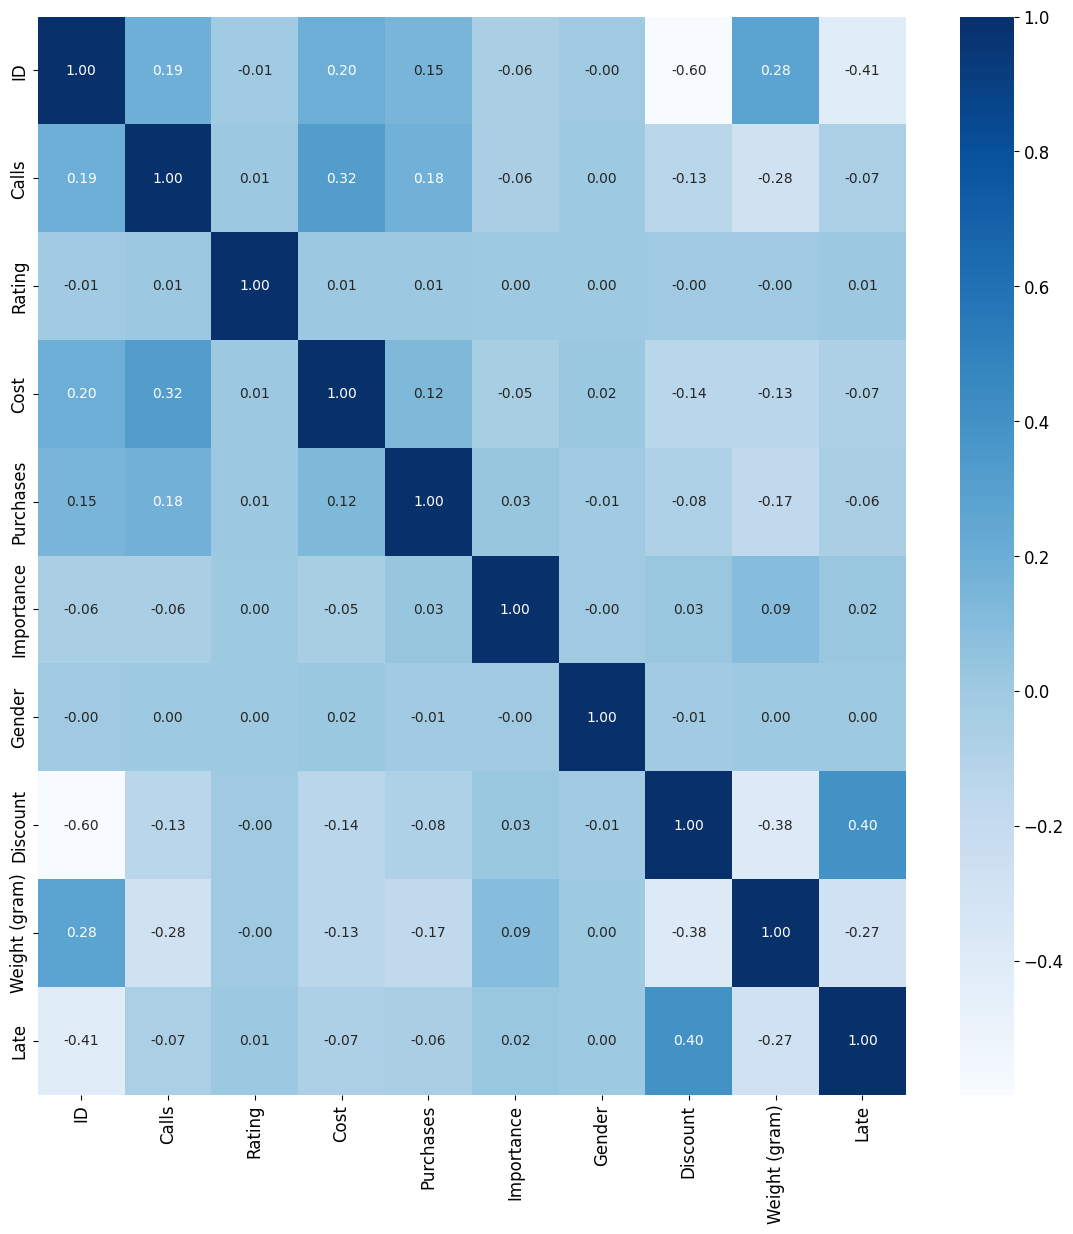

In [65]:
plt.figure(figsize=(14, 14))
sns.heatmap(df[numericals].corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show()

Analisis Heatmap plot: <br>
- Menghapus feature `ID` dan `rating` dikarenakan feature tersebut tidak memiliki arti penting untuk kegunaan proses modelling.
- Dari heatmap plot, tidak ada feature yang perlu dihapus karena tidak ada feature yang redundant dengan nilai korelasi antar feature > 0.7.

In [67]:
robust_df = robust_df.drop(['ID', 'Rating'], axis=1)

In [68]:
robust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Warehouse      10999 non-null  object 
 1   Shipment       10999 non-null  object 
 2   Calls          10999 non-null  float64
 3   Cost           10999 non-null  float64
 4   Purchases      10999 non-null  float64
 5   Importance     10999 non-null  int64  
 6   Gender         10999 non-null  int64  
 7   Discount       10999 non-null  float64
 8   Weight (gram)  10999 non-null  float64
 9   Late           10999 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 859.4+ KB


In [68]:
# #ubah boolean menjadi int (proses one hot, apabila diperlukan)

# boolean = ['Warehouse_A','Warehouse_B','Warehouse_C','Warehouse_D','Warehouse_F','Shipment_Flight','Shipment_Road','Shipment_Ship']

# df[boolean] = df[boolean].astype(int)

### **B. Feature Extraction**

In [69]:
robust_df

,Warehouse,Shipment,Calls,Cost,Purchases,Importance,Gender,Discount,Weight (gram),Late
0,D,Flight,0.0,-0.451220,0.0,0,0,6.166667,-0.908270,0.0
1,F,Flight,0.0,0.024390,-1.0,0,1,8.666667,-0.330478,0.0
2,A,Flight,-1.0,-0.378049,1.0,0,1,6.833333,-0.241395,0.0
3,B,Flight,-0.5,-0.463415,1.0,1,1,0.500000,-0.925713,0.0
4,C,Flight,-1.0,-0.365854,0.0,1,0,6.500000,-0.518611,0.0
...,...,...,...,...,...,...,...,...,...,...
10994,A,Ship,0.0,0.463415,2.0,1,0,-1.000000,-0.813269,0.0
10995,B,Ship,0.0,0.219512,2.0,1,0,-0.166667,-0.903909,-1.0
10996,C,Ship,0.5,0.341463,2.0,0,0,-0.500000,-0.932565,-1.0
10997,F,Ship,0.5,0.109756,3.0,1,1,-0.833333,-0.915434,-1.0


Pengamatan: untuk feature extraction masih belum bisa dilakukan karena tidak ada feature yang bisa di ekstraksi

### **C. Feature Tambahan**

1. Fitur durasi waktu pengiriman 
2. 

## *APPENDIX*


### Handle Class Imbalance


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


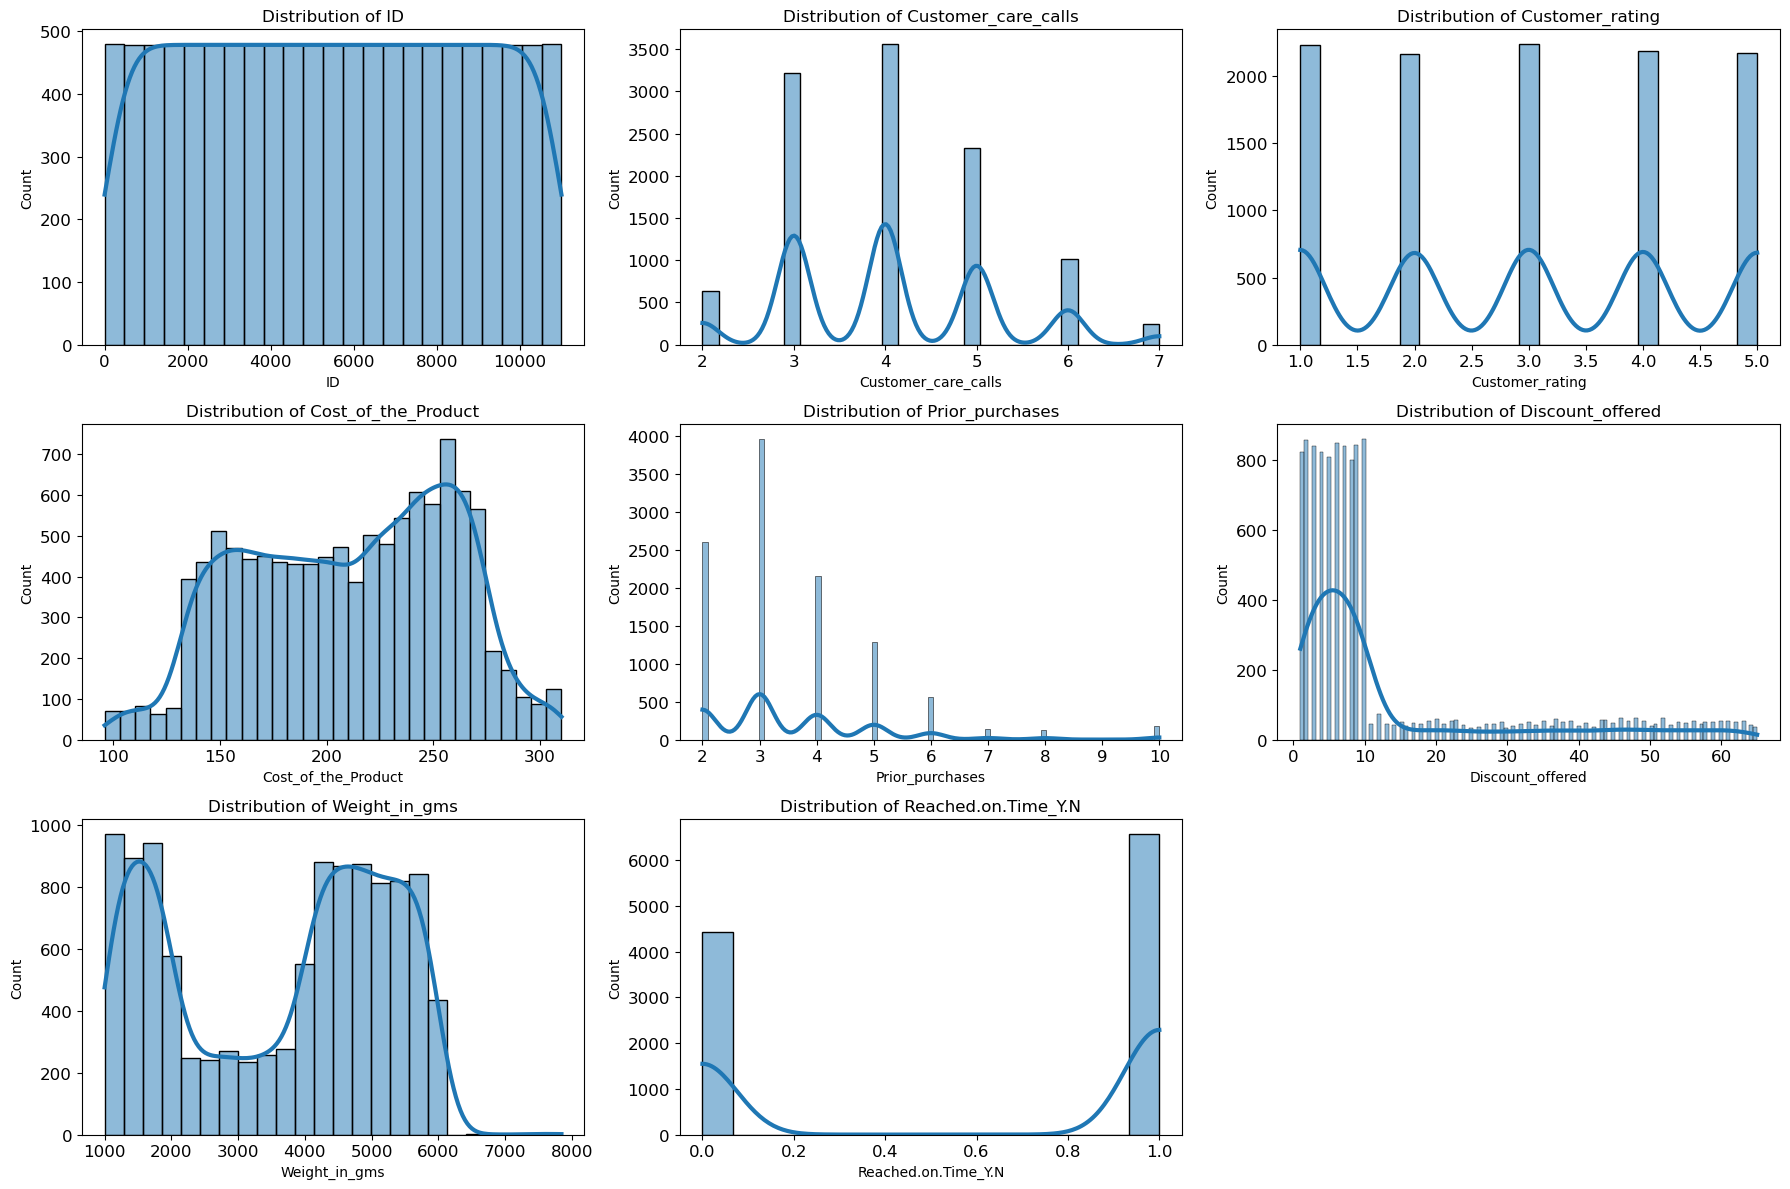

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numeric_distribution(df):
    # Pilih kolom numerik
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Hitung jumlah subplot yang dibutuhkan
    num_plots = len(num_cols)
    num_rows = (num_plots - 1) // 3 + 1  # Menggunakan integer division untuk mendapatkan jumlah baris

    # Visualisasi distribusi fitur numerik
    plt.figure(figsize=(18, 12))
    for i in range(num_plots):
        plt.subplot(num_rows, 3, i+1)  # Menyesuaikan dengan jumlah kolom (3) dan jumlah baris
        sns.histplot(df[num_cols[i]], kde=True)
        plt.title(f'Distribution of {num_cols[i]}')
        plt.tight_layout()

    plt.show()

plot_numeric_distribution(df)


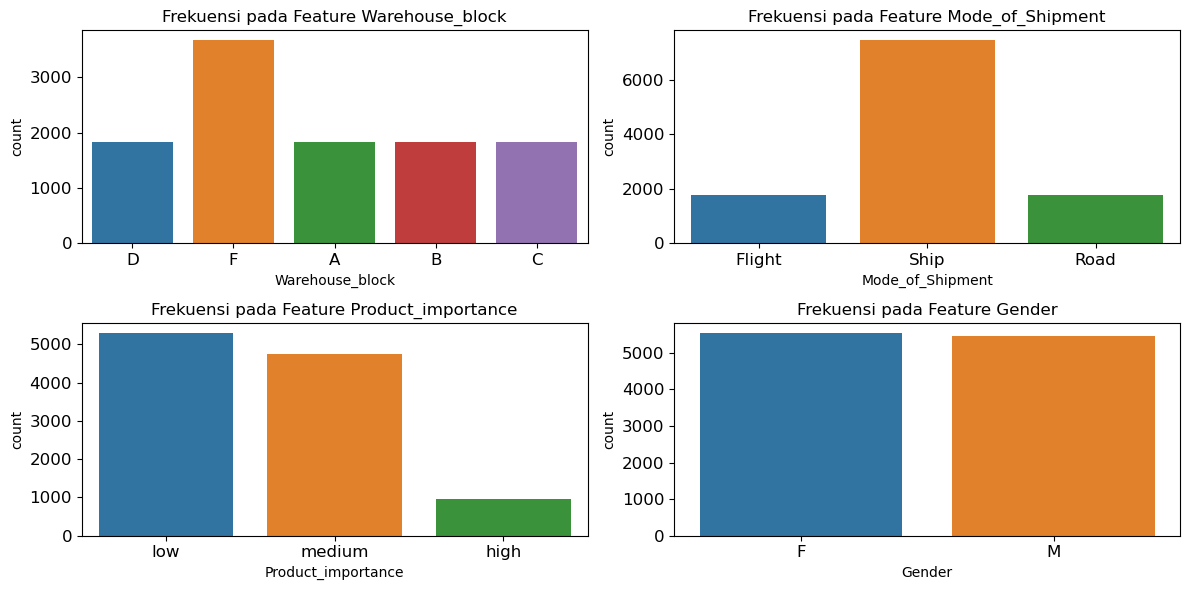

In [9]:
# Distriusi feature kategorikal
plt.figure(figsize = (12,6))
for i in range(0, len(cat)):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=df[cat[i]])
    plt.title(f'Frekuensi pada Feature {cat[i]}')
    plt.tight_layout()